## Simulación

In [241]:
import random
import numpy as np
import os
import pandas as pd
from tqdm import tqdm 


In [242]:
random.seed(42)

class MatchSimulation:
    def __init__(self, home_team, away_team, home_players, away_players):
        self.home_team = home_team
        self.away_team = away_team
        self.home_players = home_players
        self.away_players = away_players
        
        self.match_duration = random.randint(100, 120) 
        
        self.base_path = '/Users/luisalawson/Desktop/SoccerDefenseAnalysis/src/data'  
        self.field = np.zeros((10, 10), dtype=int) 
        self.ball_position = [5, 5] 

        self.current_team = random.choice(['home', 'away']) 
        self.mins_played = 0 
        self.score = {'home': 0, 'away': 0}  

        self.home_shots, self.away_shots = 0, 0
        self.home_passes, self.away_passes = 0, 0
        self.home_interceptions, self.away_interceptions = 0,0

    def mirror_matrix(self, matrix):
        """Damos vuelta la matriz para que se enfrenten en el juego"""
        return np.fliplr(np.flipud(matrix))

    def normalize_matrix(self, matrix, match_duration):
        """como estan en pases/errores/out/shot etc x minuto las pasamos a probabilidades"""
        total_shots = matrix * match_duration
        total_events = np.sum(total_shots)
        if total_events > 0:
            probability_matrix = total_shots / total_events
        else:
            probability_matrix = total_shots  
        return probability_matrix

    def load_player_matrix(self, team_name, player_name, matrix_name):
        """buscamos las matrices individuales (para armar al equipo)"""
        matrix_path = os.path.join(self.base_path, team_name, player_name, f'{matrix_name}.npy')
        return np.load(matrix_path)

    def aggregate_team_matrices(self, team_name, players):
        """sumamos para el equipo"""

        team_matrices = {
            'pass_transition_matrix': np.zeros((10, 10, 10, 10)),
            'pass_matrix':  np.zeros((10, 10)),
            'shot_matrix': np.zeros((10, 10)),
            'defense_matrix': np.zeros((10, 10)),
            'goal_matrix': np.zeros((10, 10)),
            'error_matrix': np.zeros((10, 10)),
            'out_matrix': np.zeros((10, 10))  
        }

        for player_name in players:
            team_matrices['pass_transition_matrix'] += self.load_player_matrix(team_name, player_name, 'pass_transition_matrix')
            team_matrices['pass_matrix'] += self.load_player_matrix(team_name, player_name, 'pass_matrix')
            team_matrices['shot_matrix'] += self.load_player_matrix(team_name, player_name, 'shot_matrix')
            team_matrices['defense_matrix'] += self.load_player_matrix(team_name, player_name, 'defense_matrix')
            team_matrices['goal_matrix'] += self.load_player_matrix(team_name, player_name, 'goal_matrix')
            team_matrices['error_matrix'] += self.load_player_matrix(team_name, player_name, 'errors_matrix')
            team_matrices['out_matrix'] += self.load_player_matrix(team_name, player_name, 'out_matrix')  

        return team_matrices


    def get_team_data(self):
        """Cargar y preparar las matrices para los equipos"""

        home_matrixes = self.aggregate_team_matrices(self.home_team, self.home_players)
        self.home_data = {
            'pass_transition_matrix': home_matrixes['pass_transition_matrix'], 
            'pass_matrix': self.normalize_matrix(home_matrixes['pass_matrix'], self.match_duration),
            'shot_matrix': self.normalize_matrix(home_matrixes['shot_matrix'], self.match_duration),
            'defense_matrix': self.normalize_matrix(home_matrixes['defense_matrix'], self.match_duration),
            'goal_matrix': self.normalize_matrix(home_matrixes['goal_matrix'], self.match_duration),
            'error_matrix': self.normalize_matrix(home_matrixes['error_matrix'], self.match_duration),
            'out_matrix': self.normalize_matrix(home_matrixes['out_matrix'], self.match_duration)
        }

        away_matrixes = self.aggregate_team_matrices(self.away_team, self.away_players)
        self.away_data = {
            'pass_transition_matrix': self.mirror_matrix(away_matrixes['pass_transition_matrix']),
            'pass_matrix': self.normalize_matrix(self.mirror_matrix(away_matrixes['pass_matrix']), self.match_duration),
            'shot_matrix': self.normalize_matrix(self.mirror_matrix(away_matrixes['shot_matrix']), self.match_duration),
            'defense_matrix': self.normalize_matrix(self.mirror_matrix(away_matrixes['defense_matrix']), self.match_duration),
            'goal_matrix': self.normalize_matrix(self.mirror_matrix(away_matrixes['goal_matrix']), self.match_duration),
            'error_matrix': self.normalize_matrix(self.mirror_matrix(away_matrixes['error_matrix']), self.match_duration),
            'out_matrix': self.normalize_matrix(self.mirror_matrix(away_matrixes['out_matrix']), self.match_duration) 
        }

        # self.print_team_matrices()
    
    def perform_pass(self, goal_matrix, transition_matrix, pass_matrix, defense_matrix, error_matrix, out_matrix, shot_matrix, current_x, current_y):
        """Realizar un pase basado en la matriz de transiciones y seleccionar el evento con probabilidades acumuladas"""

        # Probabilidades de pase desde la posición actual
        pass_probabilities = transition_matrix[current_x, current_y]
        prob_sum = np.sum(pass_probabilities)
        if not np.isclose(prob_sum, 1):
            pass_probabilities = pass_probabilities / prob_sum

        # Posiciones posibles de la cancha (10x10)
        possible_positions = [(i, j) for i in range(10) for j in range(10)]

        # Elegimos la siguiente posición del pase basado en las probabilidades
        next_position_index = np.random.choice(len(possible_positions), p=pass_probabilities.flatten())
        next_position = possible_positions[next_position_index]

        # Evaluamos las probabilidades para cada evento
        pass_probability = pass_matrix[next_position[0], next_position[1]]
        defense_probability = defense_matrix[next_position[0], next_position[1]]
        error_probability = error_matrix[current_x, current_y]
        shot_probability = shot_matrix[current_x, current_y]
        out_probability = out_matrix[current_x, current_y]

        # Normalizamos las probabilidades para que sumen 1
        total_prob = pass_probability + defense_probability + error_probability + shot_probability + out_probability
        normalized_probs = [pass_probability / total_prob, 
                            defense_probability / total_prob, 
                            error_probability / total_prob, 
                            shot_probability / total_prob, 
                            out_probability / total_prob]

        # Definimos los posibles eventos
        events = ['pass', 'interception', 'error', 'shot', 'out']

        # Seleccionamos un evento basado en las probabilidades
        selected_event = np.random.choice(events, p=normalized_probs)

        # Ejecutamos el evento seleccionado
        if selected_event == 'pass':
            # Pase exitoso
            if self.current_team == 'home':
                self.home_passes += 1
            else:
                self.away_passes += 1
            self.ball_position = list(next_position)
            #print(f"Buen pase a {self.ball_position}.")

        elif selected_event == 'interception':
            # Pase interceptado
            #print(f"Pase interceptado por la defensa en {next_position}.")
            if self.current_team == 'home':
                self.away_interceptions += 1
            else:
                self.home_interceptions += 1
            self.change_possession()

        elif selected_event == 'error':
            # Error del equipo con la posesión
            #print(f"Error del equipo {self.current_team}.")
            self.change_possession()

        elif selected_event == 'shot':
            # Tiro al arco
            #print(f"{self.current_team} intenta un tiro desde {current_x}, {current_y}.")
            self.shoot_ball(goal_matrix, defense_matrix, error_matrix, current_x, current_y)

        elif selected_event == 'out':
            # El balón se va fuera del campo
            #print(f"El equipo {self.current_team} pierde el balón, se va afuera en la posición {self.ball_position}.")
            self.change_possession()
            self.restart_from_sideline(next_position)  # Reiniciar desde la banda más cercana



    def change_possession(self):
        self.current_team = 'home' if self.current_team == 'away' else 'away'

    def step(self):
        events_per_minute = random.randint(20, 30)  # Aumentar el número de eventos
        for _ in range(events_per_minute):
            self.pass_ball()  
        self.mins_played += 1


    def restart_from_sideline(self, out_position):
        """Reinicia el juego desde el lado de la cancha más cercano"""
        x, y = out_position
        # Determinamos la banda más cercana
        if x <= 4:  # Cerca del lado izquierdo (x=0)
            new_x = 0
        else:  # Cerca del lado derecho (x=9)
            new_x = 9
        if y <= 4:  # Cerca de la parte superior (y=0)
            new_y = 0
        else:  # Cerca de la parte inferior (y=9)
            new_y = 9
        self.ball_position = [new_x, new_y]
        # print(f"El equipo {self.current_team} reinicia desde {self.ball_position}.")

    def pass_ball(self):
        current_x, current_y = self.ball_position
        if self.current_team == 'home':
            transition_matrix = self.home_data['pass_transition_matrix']
            pass_matrix = self.home_data['pass_matrix']
            shot_matrix = self.home_data['shot_matrix']
            defense_matrix = self.away_data['defense_matrix']
            goal_matrix = self.home_data['goal_matrix']
            error_matrix = self.home_data['error_matrix']
            out_matrix = self.home_data['out_matrix']
        else:
            transition_matrix = self.away_data['pass_transition_matrix']
            pass_matrix = self.away_data['pass_matrix']
            shot_matrix = self.away_data['shot_matrix']
            defense_matrix = self.home_data['defense_matrix']
            goal_matrix = self.away_data['goal_matrix']
            error_matrix = self.away_data['error_matrix']
            out_matrix = self.away_data['out_matrix']

    
        self.perform_pass(goal_matrix,transition_matrix, pass_matrix, defense_matrix, error_matrix, out_matrix, shot_matrix,current_x, current_y)


    def shoot_ball(self, goal_matrix, defense_matrix, error_matrix, current_x, current_y):
        """Evaluar el resultado de un tiro considerando gol, defensa y error, con un enfoque más conservador"""
        # Obtener la probabilidad de gol desde la posición actual
        goal_probability = goal_matrix[current_x, current_y]
        # Ajustar la probabilidad de gol teniendo en cuenta la defensa
        defense_probability = defense_matrix[current_x, current_y]
        adjusted_goal_prob = goal_probability * (1 - defense_probability)

        if np.random.random() < adjusted_goal_prob:
            # Gol 
            if self.current_team == 'home':
                self.score['home'] += 1
            else:
                self.score['away'] += 1

            if self.current_team == 'home':
                self.home_shots += 1
            else:
                self.away_shots += 1
            #print(f"¡GOL del equipo {self.current_team}! Resultado actual: {self.score}")
            self.ball_position = [5, 5]  # Reiniciar en el centro del campo
            self.mins_played += 2  # Añadir tiempo tras el gol
            self.change_possession()
        else:
            # Si no es gol, evaluamos si el tiro fue atajado o fue un error
            error_probability = error_matrix[current_x, current_y]
            defense_probability = 1 - adjusted_goal_prob  # Asumimos que el resto es responsabilidad de la defensa

            # Normalizar las probabilidades de error y defensa
            total_prob = defense_probability + error_probability
            normalized_probs = [defense_probability / total_prob, 
                                error_probability / total_prob]

            # Definimos los posibles resultados si no fue gol
            shot_outcomes = ['saved', 'miss']

            # Seleccionamos el resultado del tiro basado en las probabilidades
            shot_result = np.random.choice(shot_outcomes, p=normalized_probs)

            if shot_result == 'saved':
                # Tiro atajado por la defensa
                #print(f"Tiro atajado por la defensa en la posición {current_x}, {current_y}.")
                if self.current_team == 'home':
                    self.away_interceptions += 1
                else:
                    self.home_interceptions += 1
                self.change_possession()

            elif shot_result == 'miss':
                # Tiro errado por el equipo atacante
                #print(f"¡{self.current_team} intenta un tiro, pero lo erra!")
                if self.current_team == 'home':
                    self.home_shots += 1
                else:
                    self.away_shots += 1
                self.change_possession()



    def play_match(self):
        self.get_team_data()
        while self.mins_played < self.match_duration:
            self.step()
        return {
            'home': self.home_team,
            'away': self.away_team,
            'goles_local': self.score['home'],
            'goles_visitante': self.score['away'],
            'tiros_local': self.home_shots,
            'tiros_visitante': self.away_shots,
            'pases_local': self.home_passes,
            'pases_visitante': self.away_passes,
            'quites_local': self.home_interceptions,
            'quites_visitante': self.away_interceptions
        }

## Manchester United vs Chelsea

Seteamos los equipos y sus planteles (los sacamos en base al 11 titular mas elegido en la temporada)

In [243]:
home_team_name = 'Manchester United'
home_team_players = [
    'van Persie, Robin',
    'Evra, Patrice',
    'Carrick, Michael',
    'de Gea, David',
    'Ferdinand, Rio',
    'da Silva, Rafael Pereira',
    'Valencia, Luis Antonio',
    'Rooney, Wayne',
    'Evans, Jonny',
    'Vidic, Nemanja',
    'Cleverley, Tom'
]

In [244]:
away_team_name = 'Chelsea'
away_team_players = [
    'Cech, Petr',
    'Ivanovic, Branislav',
    'Cole, Ashley',
    'Mata, Juan',
    'Luiz Moreira Marinho, David',
    'Torres, Fernando',
    'Santos do Nascimento, Ramires',
    'Hazard, Eden',
    'dos Santos Emboada Junior, Oscar',
    'Cahill, Gary',
    'Azpilicueta, Cesar'   
]

## Simulamos el partido

Simulamos partidos entre manchester united y chelsea, guardamos resultados y analizamos

In [245]:
random.seed(42)
def simulate_matches(num_matches):
    results = []
    
    for _ in tqdm(range(num_matches), desc="Simulando partidos", unit="partido"):
        simulation = MatchSimulation(home_team_name, away_team_name, home_team_players, away_team_players)
        result = simulation.play_match()
        results.append(result)
    return pd.DataFrame(results)

In [246]:
random.seed(42)

df_results = simulate_matches(1000)

Simulando partidos: 100%|██████████| 1000/1000 [05:39<00:00,  2.94partido/s]


In [247]:
df_results 

,home,away,goles_local,goles_visitante,tiros_local,tiros_visitante,pases_local,pases_visitante,quites_local,quites_visitante
0,Manchester United,Chelsea,1,2,1,3,390,287,324,348
1,Manchester United,Chelsea,2,2,2,2,418,298,297,334
2,Manchester United,Chelsea,0,1,0,3,340,319,320,340
3,Manchester United,Chelsea,2,2,2,3,325,280,285,280
4,Manchester United,Chelsea,3,3,3,3,323,274,325,314
...,...,...,...,...,...,...,...,...,...,...
995,Manchester United,Chelsea,2,2,2,2,370,319,334,347
996,Manchester United,Chelsea,1,0,2,0,375,290,327,326
997,Manchester United,Chelsea,1,1,1,1,396,307,342,363
998,Manchester United,Chelsea,2,0,3,1,386,361,337,367


In [248]:
home_team_players = [
   'van Persie, Robin',
    'Welbeck, Danny',
    'Carrick, Michael',
    'de Gea, David',
    'Ferdinand, Rio',
    'da Silva, Rafael Pereira',
    'Valencia, Luis Antonio',
    'Rooney, Wayne',
    'Evans, Jonny',
    'Vidic, Nemanja',
    'Cleverley, Tom'
]

In [249]:
random.seed(42)

df_results_change = simulate_matches(1000)

Simulando partidos:   0%|          | 0/1000 [00:00<?, ?partido/s]

Simulando partidos: 100%|██████████| 1000/1000 [05:51<00:00,  2.84partido/s]


In [251]:
df_results_change

,home,away,goles_local,goles_visitante,tiros_local,tiros_visitante,pases_local,pases_visitante,quites_local,quites_visitante
0,Manchester United,Chelsea,1,0,1,0,410,327,339,360
1,Manchester United,Chelsea,0,0,2,0,475,340,333,357
2,Manchester United,Chelsea,2,2,2,2,401,308,315,360
3,Manchester United,Chelsea,3,2,3,2,370,276,287,326
4,Manchester United,Chelsea,2,1,2,1,429,352,318,345
...,...,...,...,...,...,...,...,...,...,...
995,Manchester United,Chelsea,0,0,0,0,415,340,329,354
996,Manchester United,Chelsea,0,1,0,1,420,345,342,348
997,Manchester United,Chelsea,2,4,2,4,319,281,261,292
998,Manchester United,Chelsea,2,4,2,5,383,321,330,344


In [252]:
for column_name in df_results_change.columns:
    if column_name != 'away' and column_name != 'home':
        print(f'Antes del cambio, {column_name} promedio: {df_results[column_name].mean()} \nDespues del cambio, {column_name} promedio: {df_results_change[column_name].mean()} \n')

Antes del cambio, goles_local promedio: 1.477 
Despues del cambio, goles_local promedio: 1.421 

Antes del cambio, goles_visitante promedio: 1.215 
Despues del cambio, goles_visitante promedio: 1.303 

Antes del cambio, tiros_local promedio: 1.722 
Despues del cambio, tiros_local promedio: 1.703 

Antes del cambio, tiros_visitante promedio: 1.708 
Despues del cambio, tiros_visitante promedio: 1.824 

Antes del cambio, pases_local promedio: 366.009 
Despues del cambio, pases_local promedio: 389.504 

Antes del cambio, pases_visitante promedio: 300.263 
Despues del cambio, pases_visitante promedio: 303.363 

Antes del cambio, quites_local promedio: 316.355 
Despues del cambio, quites_local promedio: 313.87 

Antes del cambio, quites_visitante promedio: 333.021 
Despues del cambio, quites_visitante promedio: 341.155 



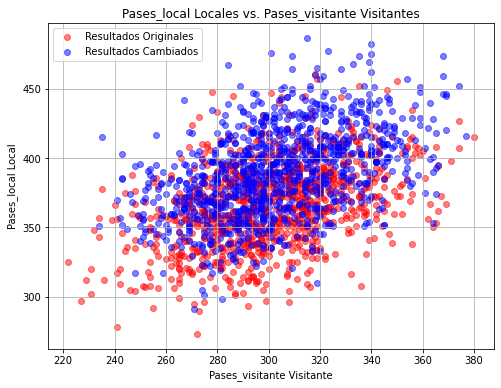

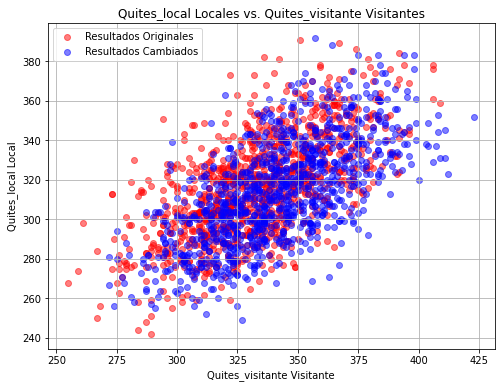

In [254]:
import matplotlib.pyplot as plt

# Crear una función para graficar las métricas
def plot_metric(df1, df2, metric_local, metric_visit, label1='df_results', label2='df_results_change'):
    plt.figure(figsize=(8, 6))

    # Graficar los datos del primer DataFrame
    plt.scatter(df1[metric_visit], df1[metric_local], color='red', alpha=0.5, label=label1)

    # Graficar los datos del segundo DataFrame
    plt.scatter(df2[metric_visit], df2[metric_local], color='blue', alpha=0.5, label=label2)

    # Configurar etiquetas y título
    plt.xlabel(f'{metric_visit.capitalize()} Visitante')
    plt.ylabel(f'{metric_local.capitalize()} Local')
    plt.title(f'{metric_local.capitalize()} Locales vs. {metric_visit.capitalize()} Visitantes')
    plt.legend()

    # Mostrar la grilla para mejor visualización
    plt.grid(True)
    plt.show()

# Usar la función para graficar las diferentes métricas
plot_metric(df_results, df_results_change, 'pases_local', 'pases_visitante', label1='Resultados Originales', label2='Resultados Cambiados')
plot_metric(df_results, df_results_change, 'quites_local', 'quites_visitante', label1='Resultados Originales', label2='Resultados Cambiados')
